In [ ]:
!wget -q https://www.dropbox.com/s/43l702z5a5i2w8j/gazeta_train.txt
!wget -q https://www.dropbox.com/s/k2egt3sug0hb185/gazeta_val.txt
!wget -q https://www.dropbox.com/s/3gki5n5djs9w0v6/gazeta_test.txt

In [ ]:
!pip install razdel networkx pymorphy2 nltk rouge==0.3.1 summa

In [ ]:
!head -n 1 gazeta_train.txt
!cat gazeta_train.txt | wc -l
!cat gazeta_val.txt | wc -l
!cat gazeta_test.txt | wc -l

{"url": "https://www.gazeta.ru/financial/2011/11/30/3852658.shtml", "text": "«По итогам 2011 года чистый отток может составить примерно $80 млрд, в следующем году — около $20 млрд. При этом мы ожидаем, что со второго полугодия 2012 года начнется приток капитала», — заявил «Интерфаксу» замминистра экономического развития Андрей Клепач. Официальные прогнозы по выводу капитала из России становятся все пессимистичными: еще летом власти полагали, что из страны уйдет не более $35 млрд, в сентябре Минэкономразвития назвал цифру $50 млрд, в начале ноября Центробанк пересмотрел оценку до $70 млрд. Очередное изменение прогноза было ожидаемо: по расчетам Центробанка , за январь — октябрь чистый отток капитала достиг $64 млрд, причем в последние месяцы он ускорился: в сентябре он составил $14 млрд, в октябре — $13 млрд против среднего ежемесячного оттока в $6—8 млрд в первом полугодии. «После октябрьских данных Минэкономразвития вынуждено было изменить оценку, настаивать на $70 млрд означало ожида

In [ ]:
import json
import random

def read_gazeta_records(file_name, shuffle=True, sort_by_date=False):
    assert shuffle != sort_by_date
    records = []
    with open(file_name, "r") as r:
        for line in r:
            records.append(json.loads(line))
    if sort_by_date:
        records.sort(key=lambda x: x["date"])
    if shuffle:
        random.shuffle
    return records

In [ ]:
train_records = read_gazeta_records("gazeta_train.txt")
val_records = read_gazeta_records("gazeta_val.txt")
test_records = read_gazeta_records("gazeta_test.txt")

In [ ]:
train_records[0].keys()

dict_keys(['url', 'text', 'title', 'summary', 'date'])

In [ ]:
print(min([record["date"] for record in train_records]), end=' - ')
print(max([record["date"] for record in train_records]))
print(min([record["date"] for record in val_records]), end=' - ')
print(max([record["date"] for record in val_records]))
print(min([record["date"] for record in test_records]), end=' - ')
print(max([record["date"] for record in test_records]))

2010-06-01 10:35:49 - 2019-05-31 23:56:26
2019-06-01 08:30:00 - 2019-09-30 23:11:23
2019-10-01 08:23:02 - 2020-03-23 22:16:23


In [ ]:
from collections import Counter, namedtuple
import razdel
import pymorphy2

Stats = namedtuple("Stats", "vocabulary,lemma_vocabulary,words_counts,unique_words_counts")

def collect_stats(records, lower=True, text_max_words=3000, summary_max_words=100, nrows=1000):
    morph = pymorphy2.MorphAnalyzer()

    text_stats = Stats(Counter(),  Counter(), list(), list())
    summary_stats = Stats(Counter(),  Counter(), list(), list())

    def update_record_field_stats(field, stats, max_words):
        words = [word.text for word in razdel.tokenize(field)][:max_words]
        lemmas = [morph.parse(word)[0].normal_form for word in words]
        stats.vocabulary.update(words)
        stats.lemma_vocabulary.update(lemmas)
        stats.words_counts.append(len(words))
        stats.unique_words_counts.append(len(set(words)))

    for i, record in enumerate(records):
        if i >= nrows:
            break
        text = record["text"]
        text = text if not lower else text.lower()
        update_record_field_stats(text, text_stats, text_max_words)

        summary = record["summary"]
        summary = summary if not lower else summary.lower()
        summary_words = [word.text for word in razdel.tokenize(summary)]
        update_record_field_stats(summary, summary_stats, summary_max_words)
    return text_stats, summary_stats

In [ ]:
train_text_stats, train_summary_stats = collect_stats(train_records)
print("Train texts vocabulary size: ", len(train_text_stats.vocabulary))
print("Train texts lemma vocabulary size: ", len(train_text_stats.lemma_vocabulary))
print("Train summaries vocabulary size: ", len(train_summary_stats.vocabulary))
print("Train summaries lemma vocabulary size: ", len(train_summary_stats.lemma_vocabulary))
print("Train common lemmas summary vs text: ", len(set(train_text_stats.lemma_vocabulary.keys()) & set(train_summary_stats.lemma_vocabulary.keys())))

Train texts vocabulary size:  82978
Train texts lemma vocabulary size:  37851
Train summaries vocabulary size:  15441
Train summaries lemma vocabulary size:  9030
Train common lemmas summary vs text:  8652


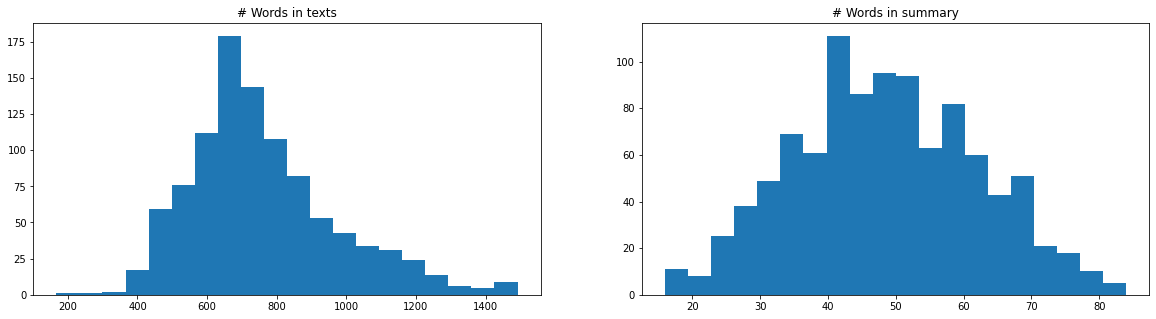

In [ ]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2, figsize=(20, 5))
axs[0].hist(train_text_stats.words_counts, 20)
axs[0].set_title('# Words in texts')

axs[1].hist(train_summary_stats.words_counts, 20)
axs[1].set_title('# Words in summary')
plt.show()

In [ ]:
from nltk.translate.bleu_score import corpus_bleu
from rouge import Rouge

def calc_scores(references, predictions, metric="all"):
    print("Count:", len(predictions))
    print("Ref:", references[-1])
    print("Hyp:", predictions[-1])

    if metric in ("bleu", "all"):
        print("BLEU: ", corpus_bleu([[r] for r in references], predictions))
    if metric in ("rouge", "all"):
        rouge = Rouge()
        scores = rouge.get_scores(predictions, references, avg=True)
        print("ROUGE: ", scores)

In [ ]:
import razdel

def calc_lead_n_score(records, n=3, lower=True, nrows=1000):
    references = []
    predictions = []

    for i, record in enumerate(records):
        if i >= nrows:
            break

        summary = record["summary"]
        summary = summary if not lower else summary.lower()
        references.append(summary)

        text = record["text"]
        text = text if not lower else text.lower()
        sentences = [sentence.text for sentence in razdel.sentenize(text)]
        prediction = " ".join(sentences[:n])
        predictions.append(prediction)

    calc_scores(references, predictions)

calc_lead_n_score(test_records, n=1)

Count: 1000
Ref: телеканал «спас» запускает реалити-шоу «остров», участникам которого предстоит месяц жить и работать в нило-столобенской пустыни на озере селигер. организаторы отметили, что это беспрецедентный подобный проект на телевидении. участникам шоу будет, где поработать — в монастыре работают свечной, молочный и столярный цеха, есть коровник, конюшня, пасека.
Hyp: православный телеканал «спас», учредителем которого является московская патриархия, запускает реалити-шоу «остров», участникам которого предстоит месяц жить и работать в нило-столобенской пустыни на озере селигер в тверской области.
BLEU:  0.19177311186434495
ROUGE:  {'rouge-1': {'f': 0.23804097238957525, 'p': 0.22208274285774904, 'r': 0.37762764047433917}, 'rouge-2': {'f': 0.10027796832321115, 'p': 0.09647636782929753, 'r': 0.15833772153385062}, 'rouge-l': {'f': 0.1835646488408507, 'p': 0.2022959168891477, 'r': 0.34937017731940756}}


### TextRank

In [ ]:
from itertools import combinations
import networkx as nx
import pymorphy2
import numpy as np
from tqdm.notebook import tqdm

def unique_words_similarity(words1, words2):
    '''
    Функция подсчёта близости предложений на основе пересечения слов
    '''
    words1 = set(words1)
    words2 = set(words2)
    if not len(words1) or not len(words2):
        return 0.0
    return len(words1.intersection(words2)) / (len(words1) + len(words2))
    #return len(words1.intersection(words2)) / (np.log10(len(words1)) + np.log10(len(words2)))

def gen_text_rank_summary(text, calc_similarity=unique_words_similarity, summary_part=0.1, lower=True, morph=None):
    '''
    Составление summary с помощью TextRank
    '''
    # Разбиваем текст на предложения
    sentences = [sentence.text for sentence in razdel.sentenize(text)]
    n_sentences = len(sentences)

    # Токенизируем предложения
    sentences_words = [[token.text.lower() if lower else token.text for token in razdel.tokenize(sentence)] for sentence in sentences]

    # При необходимости лемматизируем слова
    if morph is not None:
        sentences_words = [[morph.parse(word)[0].normal_form for word in words] for words in sentences_words]

    # Для каждой пары предложений считаем близость
    pairs = combinations(range(n_sentences), 2)
    scores = [(i, j, calc_similarity(sentences_words[i], sentences_words[j])) for i, j in pairs]

    # Строим граф с рёбрами, равными близости между предложениями
    g = nx.Graph()
    g.add_weighted_edges_from(scores)

    # Считаем PageRank

    pr = nx.pagerank(g)
    result = [(i, pr[i], s) for i, s in enumerate(sentences) if i in pr]
    result.sort(key=lambda x: x[1], reverse=True)

    # Выбираем топ предложений
    n_summary_sentences = max(int(n_sentences * summary_part), 1)
    result = result[:n_summary_sentences]

    # Восстанавливаем оригинальный их порядок
    result.sort(key=lambda x: x[0])

    num_sents = len(result)
    # Восстанавливаем текст выжимки
    predicted_summary = " ".join([sentence for i, proba, sentence in result])
    predicted_summary = predicted_summary.lower() if lower else predicted_summary
    return predicted_summary, num_sents

def calc_text_rank_score(records, calc_similarity=unique_words_similarity, summary_part=0.1, lower=True, nrows=1000, morph=None):
    references = []
    predictions = []
    length_sents = []

    for i, record in tqdm(enumerate(records)):
        if i >= nrows:
            break

        summary = record["summary"]
        summary = summary if not lower else summary.lower()
        references.append(summary)

        text = record["text"]
        predicted_summary, num_sents = gen_text_rank_summary(text, calc_similarity, summary_part, lower, morph=morph)
        length_sents.append(num_sents)
        text = text if not lower else text.lower()
        predictions.append(predicted_summary)

    print(f'Mean number of sents in summary: {np.mean(length_sents)}')
    calc_scores(references, predictions)

morph = pymorphy2.MorphAnalyzer()
calc_text_rank_score(test_records)

Mean number of sents in summary: 3.276
Count: 1000
Ref: телеканал «спас» запускает реалити-шоу «остров», участникам которого предстоит месяц жить и работать в нило-столобенской пустыни на озере селигер. организаторы отметили, что это беспрецедентный подобный проект на телевидении. участникам шоу будет, где поработать — в монастыре работают свечной, молочный и столярный цеха, есть коровник, конюшня, пасека.
Hyp: в комментарии также отмечается, что это беспрецедентный подобный проект на телевидении. съемки начнутся уже в ноябре», — указывается в анонсе. от «зенита» до «спартака», — сказал священник. в июне нынешнего года сообщалось, что рпц планирует сделать из сергиева посада «православный ватикан».
BLEU:  0.3508755059541153
ROUGE:  {'rouge-1': {'f': 0.15466400887322831, 'p': 0.16298929023222172, 'r': 0.15602281048791292}, 'rouge-2': {'f': 0.030615979709094604, 'p': 0.031077035455225686, 'r': 0.032019614611385826}, 'rouge-l': {'f': 0.13373567967669006, 'p': 0.14775573752428653, 'r': 0.1

In [ ]:
!pip install navec

In [ ]:
!wget https://storage.yandexcloud.net/natasha-navec/packs/navec_news_v1_1B_250K_300d_100q.tar

--2021-04-21 01:22:31--  https://storage.yandexcloud.net/natasha-navec/packs/navec_news_v1_1B_250K_300d_100q.tar
Resolving storage.yandexcloud.net (storage.yandexcloud.net)... 213.180.193.243, 2a02:6b8::1d9
Connecting to storage.yandexcloud.net (storage.yandexcloud.net)|213.180.193.243|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 26634240 (25M) [application/x-tar]
Saving to: ‘navec_news_v1_1B_250K_300d_100q.tar’

navec_news_v1_1B_25 100%[===================>]  25.40M  9.44MB/s    in 2.7s    

2021-04-21 01:22:35 (9.44 MB/s) - ‘navec_news_v1_1B_250K_300d_100q.tar’ saved [26634240/26634240]



In [ ]:
from navec import Navec

path = 'navec_news_v1_1B_250K_300d_100q.tar'
navec = Navec.load(path)

In [ ]:
from numpy.linalg import norm
def vectorize_sum(words, embeddings):

    embedding_dim = embeddings['example'].shape[0]
    features = np.zeros([embedding_dim], dtype='float32')

    num_known_words = 0
    for word in words:
        if word in embeddings:
            num_known_words += 1
            features += embeddings[f'{word}']

    if num_known_words:
        return features / num_known_words
    else: return features

def my_sim(text1, text2, embeddings=navec, kind='cos'):

    v1, v2 = vectorize_sum(text1, embeddings), vectorize_sum(text2, embeddings)
    if np.sum(v1) == 0.0 or np.sum(v2) == 0.0:
        return 0

    return np.abs(np.dot(v1, v2) / norm(v1) / norm(v2))

In [ ]:
calc_text_rank_score(test_records, calc_similarity=my_sim, morph=morph)

Mean number of sents in summary: 3.276
Count: 1000
Ref: телеканал «спас» запускает реалити-шоу «остров», участникам которого предстоит месяц жить и работать в нило-столобенской пустыни на озере селигер. организаторы отметили, что это беспрецедентный подобный проект на телевидении. участникам шоу будет, где поработать — в монастыре работают свечной, молочный и столярный цеха, есть коровник, конюшня, пасека.
Hyp: «у нас же даже многие журналисты не знают и не понимают многого, связанного с религиозными ценностями, а здесь — попытка обратить их внимание на это, может быть, им будет интересно. и это что — жизнь, что ли? «если человеку невоцерковленному, далекому от церкви, в двух словах сказать, для чего нужна церковь — церковь… нужна для того, чтобы был силен дух нашего народа», — говорил предстоятель. по словам патриарха, им станет тот, кто будет стоять «во главе всемирной паутины».
BLEU:  0.2736838350215274
ROUGE:  {'rouge-1': {'f': 0.15109432683062032, 'p': 0.12445104194115493, 'r': 0.

### Summa

In [ ]:
from summa.summarizer import summarize

def calc_summa_score(records, summary_part=0.1, lower=True, nrows=1000):
    references = []
    predictions = []

    for i, record in tqdm(enumerate(records)):
        if i >= nrows:
            break

        summary = record["summary"]
        summary = summary if not lower else summary.lower()
        references.append(summary)

        text = record["text"]
        text = text if not lower else text.lower()
        predicted_summary = summarize(text, ratio=summary_part, language='russian').replace("\n", " ")
        predictions.append(predicted_summary)

    calc_scores(references, predictions)

calc_summa_score(test_records)

Count: 1000
Ref: телеканал «спас» запускает реалити-шоу «остров», участникам которого предстоит месяц жить и работать в нило-столобенской пустыни на озере селигер. организаторы отметили, что это беспрецедентный подобный проект на телевидении. участникам шоу будет, где поработать — в монастыре работают свечной, молочный и столярный цеха, есть коровник, конюшня, пасека.
Hyp: проживи месяц в ниловой пустыни, выполняя послушания, и найди ответы на вопросы, которые давно беспокоят», — так анонсирует телеканал свой проект. «у нас же даже многие журналисты не знают и не понимают многого, связанного с религиозными ценностями, а здесь — попытка обратить их внимание на это, может быть, им будет интересно. стоит отметить, что участникам шоу будет, где поработать — в монастыре работают свечной, молочный и столярный цеха, есть коровник, конюшня, пасека. и это что — жизнь, что ли?
BLEU:  0.2762958192799957
ROUGE:  {'rouge-1': {'f': 0.1770425497877709, 'p': 0.14391909693539454, 'r': 0.247378763312854

## Oracle summary

In [ ]:
import copy

def build_oracle_summary_greedy(text, gold_summary, calc_score, lower=True, max_sentences=30):
    '''
    Жадное построение oracle summary
    '''
    gold_summary = gold_summary.lower() if lower else gold_summary
    # Делим текст на предложения
    sentences = [sentence.text.lower() if lower else sentence.text for sentence in razdel.sentenize(text)][:max_sentences]
    n_sentences = len(sentences)
    oracle_summary_sentences = set()

    score = -1.0
    summaries = []
    for _ in range(n_sentences):
        for i in range(n_sentences):
            if i in oracle_summary_sentences:
                continue
            current_summary_sentences = copy.copy(oracle_summary_sentences)
            # Добавляем какое-то предложения к уже существующему summary
            current_summary_sentences.add(i)
            current_summary = " ".join([sentences[index] for index in sorted(list(current_summary_sentences))])
            # Считаем метрики
            current_score = calc_score(current_summary, gold_summary)
            summaries.append((current_score, current_summary_sentences))
        # Если получилось улучшить метрики с добавлением какого-либо предложения, то пробуем добавить ещё
        # Иначе на этом заканчиваем
        best_summary_score, best_summary_sentences = max(summaries)
        if best_summary_score <= score:
            break
        oracle_summary_sentences = best_summary_sentences
        score = best_summary_score
    oracle_summary = " ".join([sentences[index] for index in sorted(list(oracle_summary_sentences))])
    return oracle_summary, oracle_summary_sentences

def calc_single_score(pred_summary, gold_summary, rouge):
    return rouge.get_scores([pred_summary], [gold_summary], avg=True)['rouge-2']['f']

In [ ]:
from tqdm.notebook import tqdm
import razdel

def calc_oracle_score(records, nrows=1000, lower=True):
    references = []
    predictions = []
    rouge = Rouge()

    for i, record in tqdm(enumerate(records)):
        if i >= nrows:
            break

        summary = record["summary"]
        summary = summary if not lower else summary.lower()
        references.append(summary)

        text = record["text"]
        predicted_summary, _ = build_oracle_summary_greedy(text, summary, calc_score=lambda x, y: calc_single_score(x, y, rouge))
        predictions.append(predicted_summary)

    calc_scores(references, predictions)


calc_oracle_score(test_records)

Count: 1000
Ref: телеканал «спас» запускает реалити-шоу «остров», участникам которого предстоит месяц жить и работать в нило-столобенской пустыни на озере селигер. организаторы отметили, что это беспрецедентный подобный проект на телевидении. участникам шоу будет, где поработать — в монастыре работают свечной, молочный и столярный цеха, есть коровник, конюшня, пасека.
Hyp: православный телеканал «спас», учредителем которого является московская патриархия, запускает реалити-шоу «остров», участникам которого предстоит месяц жить и работать в нило-столобенской пустыни на озере селигер в тверской области. в комментарии также отмечается, что это беспрецедентный подобный проект на телевидении. стоит отметить, что участникам шоу будет, где поработать — в монастыре работают свечной, молочный и столярный цеха, есть коровник, конюшня, пасека.
BLEU:  0.531336150784986
ROUGE:  {'rouge-1': {'f': 0.36951810858804146, 'p': 0.4053281117404892, 'r': 0.3661389123393327}, 'rouge-2': {'f': 0.2087846693590

## Extractive RNN

In [ ]:
!pip install youtokentome

     |████████████████████████████████| 1.7MB 8.7MB/s 


In [ ]:
import youtokentome as yttm

def train_bpe(records, model_path, model_type="bpe", vocab_size=10000, lower=True):
    temp_file_name = "temp.txt"
    with open(temp_file_name, "w") as temp:
        for record in records:
            text, summary = record['text'], record['summary']
            if lower:
                summary = summary.lower()
                text = text.lower()
            if not text or not summary:
                continue
            temp.write(text + "\n")
            temp.write(summary + "\n")
    yttm.BPE.train(data=temp_file_name, vocab_size=vocab_size, model=model_path)

train_bpe(train_records, "BPE_model.bin")

In [ ]:
bpe_processor = yttm.BPE('BPE_model.bin')
bpe_processor.encode('привет. это я, убегаю от тебя', output_type=yttm.OutputType.SUBWORD)

['▁привет', '.', '▁это', '▁я', ',', '▁убе', 'га', 'ю', '▁от', '▁тебя']

In [ ]:
words = ['▁привет', '▁это', '▁я', ',', '▁убе', 'га', 'ю', '▁от', '▁тебя']

In [ ]:
bpe_processor.decode([bpe_processor.subword_to_id(word) for word in words])

['привет это я, убегаю от тебя']

In [ ]:
vocabulary = bpe_processor.vocab()

In [ ]:
from rouge import Rouge
import razdel
from tqdm.notebook import tqdm

def add_oracle_summary_to_records(records, max_sentences=30, lower=True, nrows=1000):
    rouge = Rouge()
    for i, record in tqdm(enumerate(records)):
        if i >= nrows:
            break
        text = record["text"]
        summary = record["summary"]

        summary = summary.lower() if lower else summary
        sentences = [sentence.text.lower() if lower else sentence.text for sentence in razdel.sentenize(text)][:max_sentences]
        oracle_summary, sentences_indicies = build_oracle_summary_greedy(text, summary, calc_score=lambda x, y: calc_single_score(x, y, rouge),
                                                                         lower=lower, max_sentences=max_sentences)
        record["sentences"] = sentences
        record["oracle_sentences"] = list(sentences_indicies)
        record["oracle_summary"] = oracle_summary

    return records[:nrows]

ext_train_records = add_oracle_summary_to_records(train_records, nrows=2048)
ext_val_records = add_oracle_summary_to_records(val_records, nrows=256)
ext_test_records = add_oracle_summary_to_records(test_records, nrows=256)

In [ ]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [ ]:
import random
import math
import razdel
import torch
import numpy as np
from rouge import Rouge


class BatchIterator():
    def __init__(self, records, vocabulary, batch_size, bpe_processor, shuffle=True, lower=True, max_sentences=30, max_sentence_length=50, device=torch.device('cpu')):
        self.records = records
        self.num_samples = len(records)
        self.batch_size = batch_size
        self.bpe_processor = bpe_processor
        self.shuffle = shuffle
        self.batches_count = int(math.ceil(self.num_samples / batch_size))
        self.lower = lower
        self.rouge = Rouge()
        self.vocabulary = vocabulary
        self.max_sentences = max_sentences
        self.max_sentence_length = max_sentence_length
        self.device = device

    def __len__(self):
        return self.batches_count

    def __iter__(self):
        indices = np.arange(self.num_samples)
        if self.shuffle:
            np.random.shuffle(indices)

        for start in range(0, self.num_samples, self.batch_size):
            end = min(start + self.batch_size, self.num_samples)
            batch_indices = indices[start:end]

            batch_inputs = []
            batch_outputs = []
            max_sentence_length = 0
            max_sentences = 0
            batch_records = []

            for data_ind in batch_indices:

                record = self.records[data_ind]
                batch_records.append(record)
                text = record["text"]
                summary = record["summary"]
                summary = summary.lower() if self.lower else summary

                if "sentences" not in record:
                    sentences = [sentence.text.lower() if self.lower else sentence.text for sentence in razdel.sentenize(text)][:self.max_sentences]
                else:
                    sentences = record["sentences"]
                max_sentences = max(len(sentences), max_sentences)

                # номера предложений, которые в нашем саммари
                if "oracle_sentences" not in record:
                    calc_score = lambda x, y: calc_single_score(x, y, self.rouge)
                    sentences_indicies = build_oracle_summary_greedy(text, summary, calc_score=calc_score, lower=self.lower, max_sentences=self.max_sentences)[1]
                else:
                    sentences_indicies = record["oracle_sentences"]

                # inputs - индексы слов в предложении
                inputs = [bpe_processor.encode(sentence)[:self.max_sentence_length] for sentence in sentences]
                max_sentence_length = max(max_sentence_length, max([len(tokens) for tokens in inputs]))

                # получение метки класса предложения
                outputs = [int(i in sentences_indicies) for i in range(len(sentences))]
                batch_inputs.append(inputs)
                batch_outputs.append(outputs)

            tensor_inputs = torch.zeros((self.batch_size, max_sentences, max_sentence_length), dtype=torch.long, device=self.device)
            tensor_outputs = torch.zeros((self.batch_size, max_sentences), dtype=torch.float32, device=self.device)


            for i, inputs in enumerate(batch_inputs):
                for j, sentence_tokens in enumerate(inputs):
                    tensor_inputs[i][j][:len(sentence_tokens)] = torch.LongTensor(sentence_tokens)

            for i, outputs in enumerate(batch_outputs):
                tensor_outputs[i][:len(outputs)] = torch.LongTensor(outputs)

            yield {
                'inputs': tensor_inputs,
                'outputs': tensor_outputs,
                'records': batch_records
            }

In [ ]:
train_iterator = BatchIterator(ext_train_records, vocabulary, 4, bpe_processor, device=device)

In [ ]:
for batch in train_iterator:
    break

In [ ]:
batch['records'][0].keys()

dict_keys(['url', 'text', 'title', 'summary', 'date', 'sentences', 'oracle_sentences', 'oracle_summary'])

In [ ]:
train_iterator = BatchIterator(ext_train_records, vocabulary, 32, bpe_processor, device=device)
val_iterator = BatchIterator(ext_val_records, vocabulary, 32, bpe_processor, device=device)
test_iterator = BatchIterator(ext_test_records, vocabulary, 32, bpe_processor, device=device)

SummaRuNNer


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import time

def train_model(model, train_iterator, val_iterator, vocabulary, bpe_processor,
                epochs_count=2, loss_every_nsteps=16, lr=0.001, device_name="cuda"):

    params_count = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print("Trainable params: {}".format(params_count))

    device = torch.device(device_name)
    model = model.to(device)

    total_loss = 0
    start_time = time.time()

    optimizer = optim.Adam(model.parameters(), lr=lr)
    loss_function = nn.BCEWithLogitsLoss().to(device)

    for epoch in range(epochs_count):
        for step, batch in enumerate(train_iterator):

            model.train()
            logits = model(batch["inputs"]) # Прямой проход
            loss = loss_function(logits, batch["outputs"]) # Подсчёт ошибки

            optimizer.zero_grad() # Зануление градиентов, чтобы их спокойно менять на следующей итерации
            loss.backward() # Подсчёт градиентов dL/dw
            optimizer.step() # Градиентный спуск или его модификации (в данном случае Adam)

            total_loss += loss.item()
            if step % loss_every_nsteps == 0 and step != 0:
                val_total_loss = 0
                val_batch_count = 0

                model.eval()
                for _, val_batch in enumerate(val_iterator):

                    logits = model(val_batch["inputs"]) # Прямой проход
                    val_total_loss += loss_function(logits, batch["outputs"]) # Подсчёт ошибки
                    val_batch_count += 1

                avg_val_loss = val_total_loss/val_batch_count
                print("Epoch = {}, Avg Train Loss = {:.4f}, Avg val loss = {:.4f}, Time = {:.2f}s".format(epoch, total_loss / loss_every_nsteps, avg_val_loss, time.time() - start_time))
                total_loss = 0
                start_time = time.time()

        total_loss = 0
        start_time = time.time()

In [ ]:
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

from torch.nn.utils.rnn import pack_padded_sequence as pack
from torch.nn.utils.rnn import pad_packed_sequence as unpack

class SentenceEncoderRNN(nn.Module):
    def __init__(self, input_size, embedding_dim, hidden_size, n_layers=3, dropout=0.3, bidirectional=True):
        super().__init__()

        num_directions = 2 if bidirectional else 1
        assert hidden_size % num_directions == 0
        hidden_size = hidden_size // num_directions

        self.embedding_dim = embedding_dim
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        self.dropout = dropout
        self.bidirectional = bidirectional

        self.embedding_layer = nn.Embedding(input_size, embedding_dim)
        self.rnn_layer = nn.LSTM(embedding_dim, hidden_size, n_layers, dropout=dropout, bidirectional=bidirectional, batch_first=True)
        self.dropout_layer = nn.Dropout(dropout)

    def forward(self, inputs, hidden=None):
        embedded = self.embedding_layer(inputs)
        outputs, _ = self.rnn_layer(embedded, hidden)
        sentences_embeddings = torch.mean(outputs, 1)
        # [batch_size, hidden_size]
        return sentences_embeddings

class SentenceTaggerRNN(nn.Module):
    def __init__(self,
                 vocabulary_size,
                 token_embedding_dim=256,
                 sentence_encoder_hidden_size=256,
                 hidden_size=256,
                 bidirectional=True,
                 sentence_encoder_n_layers=2,
                 sentence_encoder_dropout=0.3,
                 sentence_encoder_bidirectional=True,
                 n_layers=1,
                 dropout=0.3):

        super().__init__()

        num_directions = 2 if bidirectional else 1
        assert hidden_size % num_directions == 0
        hidden_size = hidden_size // num_directions

        self.hidden_size = hidden_size
        self.n_layers = n_layers
        self.dropout = dropout
        self.bidirectional = bidirectional

        self.sentence_encoder = SentenceEncoderRNN(vocabulary_size, token_embedding_dim,
                                                   sentence_encoder_hidden_size, sentence_encoder_n_layers,
                                                   sentence_encoder_dropout, sentence_encoder_bidirectional)

        self.rnn_layer = nn.LSTM(sentence_encoder_hidden_size, hidden_size, n_layers, dropout=dropout,
                           bidirectional=bidirectional, batch_first=True)

        self.dropout_layer = nn.Dropout(dropout)
        self.content_linear_layer = nn.Linear(hidden_size * 2, 1)
        self.document_linear_layer = nn.Linear(hidden_size * 2, hidden_size * 2)
        self.salience_linear_layer = nn.Linear(hidden_size * 2, hidden_size * 2)
        self.tanh_layer = nn.Tanh()

    def forward(self, inputs, hidden=None):

        # [batch_size, seq num, seq_len]
        batch_size = inputs.size(0)
        sentences_count = inputs.size(1)
        tokens_count = inputs.size(2)
        inputs = inputs.reshape(-1, tokens_count)
        # [batch_size * seq num, seq_len]

        embedded_sentences = self.sentence_encoder(inputs)
        embedded_sentences = embedded_sentences.reshape(batch_size, sentences_count, -1)
        # [batch_size *  seq num, seq_len, hidden_size] -> [batch_size, seq num, hidden_size]

        outputs, _ = self.rnn_layer(embedded_sentences, hidden)
        outputs = self.dropout_layer(outputs)
        # [batch_size, seq num, hidden_size]

        document_embedding = self.tanh_layer(self.document_linear_layer(torch.mean(outputs, 1)))
        # [batch_size, hidden_size]

        # W * h^T
        content = self.content_linear_layer(outputs).squeeze(2) # 1-representation
        # [batch_size, seq num]

        # h^T * W * d
        salience = torch.bmm(outputs, self.salience_linear_layer(document_embedding).unsqueeze(2)).squeeze(2) # 2-representation

        # [batch_size, seq num, hidden_size] * [batch_size, hidden_size, 1] = [batch_size, seq num, ]
        return content + salience

In [ ]:
model = SentenceTaggerRNN(len(vocabulary))
train_model(model, train_iterator, val_iterator, vocabulary, bpe_processor, device_name="cuda")

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/rnn.py:61: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


Trainable params: 3877633
Epoch = 0, Avg Train Loss = 0.3204, Avg val loss = 0.2028, Time = 2.70s
Epoch = 0, Avg Train Loss = 0.2402, Avg val loss = 0.2429, Time = 2.38s
Epoch = 0, Avg Train Loss = 0.2402, Avg val loss = 0.2244, Time = 2.39s
Epoch = 1, Avg Train Loss = 0.2528, Avg val loss = 0.2247, Time = 2.49s
Epoch = 1, Avg Train Loss = 0.2284, Avg val loss = 0.2138, Time = 2.39s
Epoch = 1, Avg Train Loss = 0.2321, Avg val loss = 0.2313, Time = 2.36s


In [ ]:
import re
def punct_detokenize(text):
    text = text.strip()
    punctuation = ",.!?:;%"
    closing_punctuation = ")]}"
    opening_punctuation = "([}"
    for ch in punctuation + closing_punctuation:
        text = text.replace(" " + ch, ch)
    for ch in opening_punctuation:
        text = text.replace(ch + " ", ch)
    res = [r'"\s[^"]+\s"', r"'\s[^']+\s'"]
    for r in res:
        for f in re.findall(r, text, re.U):
            text = text.replace(f, f[0] + f[2:-2] + f[-1])
    text = text.replace("' s", "'s").replace(" 's", "'s")
    text = text.strip()
    return text


def postprocess(ref, hyp, is_multiple_ref=False, detokenize_after=False, tokenize_after=True):
    if is_multiple_ref:
        reference_sents = ref.split(" s_s ")
        decoded_sents = hyp.split("s_s")
        hyp = [w.replace("<", "&lt;").replace(">", "&gt;").strip() for w in decoded_sents]
        ref = [w.replace("<", "&lt;").replace(">", "&gt;").strip() for w in reference_sents]
        hyp = " ".join(hyp)
        ref = " ".join(ref)
    ref = ref.strip()
    hyp = hyp.strip()
    if detokenize_after:
        hyp = punct_detokenize(hyp)
        ref = punct_detokenize(ref)
    if tokenize_after:
        hyp = hyp.replace("@@UNKNOWN@@", "<unk>")
        hyp = " ".join([token.text for token in razdel.tokenize(hyp)])
        ref = " ".join([token.text for token in razdel.tokenize(ref)])
    return ref, hyp

def inference_summarunner(model, iterator, top_k=3):

    references = []
    predictions = []

    model.eval()
    for batch in test_iterator:

        logits = model(batch['inputs'])
        sum_in = torch.argsort(logits, dim=1)[:, -top_k:]

        for i in range(len(batch['outputs'])):

            summary = batch['records'][i]['summary'].lower()
            pred_summary = ' '.join([batch['records'][i]['sentences'][ind] for ind in sum_in.sort(dim=1)[0][i]])

            summary, pred_summary= postprocess(summary, pred_summary)

            references.append(summary)
            predictions.append(pred_summary)

    calc_scores(references, predictions)

inference_summarunner(model, test_iterator, 3)

Count: 256
Ref: россиянам на время эпидемии вируса covid-2019 стоит как можно реже выезжать за границу — рассказала глава роспотребнадзора анна попова . также в ведомстве добавили , что сейчас российскими госорганами приняты дополнительные меры по усилению санитарно-карантинного контроля в пунктах пропуска через государственную границу рф .
Hyp: руководитель федеральной службы по надзору в сфере защиты прав потребителей и благополучия человека ( роспотребнадзор ) анна попова посоветовала россиянам на время эпидемии вируса covid-2019 как можно реже выезжать за границу . « для того чтобы считать себя защищенными , первое — нужно максимально сократить возможные , предполагавшиеся поездки за рубежи родной страны . вот сегодня то время , когда не стоит выезжать из российской федерации » , — приводит риа « новости » слова главы ведомства .
BLEU:  0.44844751734705157
ROUGE:  {'rouge-1': {'f': 0.31869023033378224, 'p': 0.30429000941673057, 'r': 0.35484617993765427}, 'rouge-2': {'f': 0.14387508